#Task 3

In [39]:
# cell 1 setup and rcparams

# dont print warnings too much noise in colab
import warnings
warnings.filterwarnings("ignore")

import math, random, os, copy, time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import pandas as pd

# figure look for icml ready export
import matplotlib
matplotlib.rcParams.update({
    "figure.dpi": 100,
    "savefig.dpi": 600,
    "font.family": "DejaVu Serif",
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "axes.linewidth": 1.2
})

# seeds for repeat runs
SEED = 27100162
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", DEVICE)


device: cuda


Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 259, in _feed
    reader_close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 259, in _feed
    reader_close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


In [40]:
# cell 2 config values and helpers  safe for colab dataloader workers

import os, gc
# dataset and loader config
NUM_CLIENTS = 5
BATCH_SIZE  = 64

# hard stop dataloader workers to avoid "can only test a child process" noise
# jupyter colab plus py3.12 multiprocessing + dataloader cleanup can be flaky
NUM_WORKERS = 0

# fedavg training config for task 3
ROUNDS       = 20            # keep compute light, flip to 50 later if you want
LOCAL_EPOCHS = 5
LR           = 0.01
MOMENTUM     = 0.9
WEIGHT_DECAY = 5e-4

# dirichlet alpha values
ALPHAS = [100.0, 1.0, 0.2, 0.05]

# figure save toggle
SAVE_FIGS = False
FIG_DIR = "figs_task3"
os.makedirs(FIG_DIR, exist_ok=True)

def human_time(sec):
    m, s = divmod(sec, 60)
    return f"{int(m)}m {int(s)}s"

print("config ready  num_workers =", NUM_WORKERS)


config ready  num_workers = 0


In [41]:
# cell 2a optional stronger run preset from the manual example
# set this true when you want the 50 rounds K 10 run
USE_STRONG_SETUP = False
if USE_STRONG_SETUP:
    ROUNDS = 50
    LOCAL_EPOCHS = 10
    print("using stronger setup", ROUNDS, "rounds and", LOCAL_EPOCHS, "local epochs")


In [42]:
# cell 3 model def small cnn for cifar

class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        self.pool  = nn.MaxPool2d(2, 2)
        self.drop  = nn.Dropout(0.25)
        self.fc1   = nn.Linear(64*8*8, 128)
        self.fc2   = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = torch.flatten(x, 1)
        x = self.drop(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

def count_params(m):
    return sum(p.numel() for p in m.parameters())

base_model = SmallCNN().to(DEVICE)
print("params:", count_params(base_model))


params: 545290


In [43]:
# cell 4 load cifar ten once

train_tf = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

root = "./data"
train_set = datasets.CIFAR10(root=root, train=True, download=True, transform=train_tf)
test_set  = datasets.CIFAR10(root=root, train=False, download=True, transform=test_tf)

test_loader = DataLoader(
    test_set,
    batch_size=256,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=(DEVICE.type == "cuda")
)
print("train size:", len(train_set), "test size:", len(test_set))


train size: 50000 test size: 10000


In [44]:
# cell 5 dirichlet partition function

def dirichlet_partition(labels, num_clients, alpha, min_size=10):
    n_classes = labels.max() + 1
    idx_by_class = [np.where(labels == c)[0] for c in range(n_classes)]
    for arr in idx_by_class:
        np.random.shuffle(arr)

    client_indices = [[] for _ in range(num_clients)]
    for c in range(n_classes):
        idx_c = idx_by_class[c]
        if len(idx_c) == 0:
            continue
        p = np.random.dirichlet(alpha=np.ones(num_clients) * alpha)
        counts = (p * len(idx_c)).astype(int)
        diff = len(idx_c) - counts.sum()
        if diff > 0:
            for i in np.argsort(-p)[:diff]:
                counts[i] += 1
        elif diff < 0:
            for i in np.argsort(p)[:abs(diff)]:
                counts[i] = max(0, counts[i] - 1)
        start = 0
        for i, ct in enumerate(counts):
            if ct > 0:
                client_indices[i].extend(idx_c[start:start+ct].tolist())
                start += ct

    for i in range(num_clients):
        np.random.shuffle(client_indices[i])
        if len(client_indices[i]) < min_size:
            need = min_size - len(client_indices[i])
            donors = np.argsort([-len(client_indices[j]) for j in range(num_clients)])
            for d in donors:
                if d == i:
                    continue
                take = min(need, max(0, len(client_indices[d]) - min_size))
                if take > 0:
                    moved = client_indices[d][:take]
                    client_indices[d] = client_indices[d][take:]
                    client_indices[i].extend(moved)
                    need -= take
                if need <= 0:
                    break
        np.random.shuffle(client_indices[i])
    return client_indices

def build_client_loaders(dataset, indices_list, batch_size):
    loaders = []
    sizes   = []
    for idxs in indices_list:
        subset = Subset(dataset, idxs)
        loader = DataLoader(
            subset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=NUM_WORKERS,
            pin_memory=(DEVICE.type == "cuda")
        )
        loaders.append(loader)
        sizes.append(len(subset))
    return loaders, sizes


In [45]:
# cell 6 prepare loaders for each alpha and store class mix to plot

y_all = np.array(train_set.targets)

def class_mix_per_client(indices_list, labels, num_classes=10):
    mix = []
    for idxs in indices_list:
        if len(idxs) == 0:
            mix.append(np.zeros(num_classes, dtype=int))
        else:
            vals, counts = np.unique(labels[idxs], return_counts=True)
            row = np.zeros(num_classes, dtype=int)
            row[vals] = counts
            mix.append(row)
    return np.stack(mix, axis=0)

alpha_to_splits = {}
alpha_to_mix    = {}
alpha_to_sizes  = {}

for a in ALPHAS:
    splits = dirichlet_partition(y_all, NUM_CLIENTS, a, min_size=50)
    mix    = class_mix_per_client(splits, y_all, num_classes=10)
    loaders, sizes = build_client_loaders(train_set, splits, BATCH_SIZE)
    alpha_to_splits[a] = (loaders, sizes)
    alpha_to_mix[a]    = mix
    alpha_to_sizes[a]  = sizes

print("made splits for all alphas")


made splits for all alphas


In [46]:
# cell 6a validate dirichlet splits and show small assigned class counts

def report_split_stats(mix):
    # mix shape clients by classes counts
    stats = []
    for i in range(mix.shape[0]):
        row = mix[i]
        total = int(row.sum())
        nonzero = int((row > 0).sum())
        min_assigned = int(row[row > 0].min()) if nonzero > 0 else 0
        # show top classes to see dominance
        top2_idx = row.argsort()[-2:][::-1]
        frac_top1 = float(row[top2_idx[0]] / total) if total > 0 else 0.0
        frac_top2 = float(row[top2_idx[1]] / total) if total > 0 else 0.0
        stats.append((total, nonzero, min_assigned, frac_top1, frac_top2))
    df = pd.DataFrame(stats, columns=["samples","nonzero_classes","min_count_over_assigned_classes","top1_frac","top2_frac"])
    return df

for a in ALPHAS:
    print("alpha", a)
    df_stats = report_split_stats(alpha_to_mix[a])
    print(df_stats.to_string(index=True))
    # simple warning for very tiny assigned class counts
    if (df_stats["min_count_over_assigned_classes"] < 5).any():
        print("note some clients have very tiny class bins under 5 samples")
    print()


alpha 100.0
   samples  nonzero_classes  min_count_over_assigned_classes  top1_frac  top2_frac
0    10249               10                              852   0.117182   0.108011
1    10390               10                              845   0.115688   0.108662
2     9706               10                              879   0.113435   0.104884
3     9693               10                              890   0.111730   0.106056
4     9962               10                              843   0.114636   0.109416

alpha 1.0
   samples  nonzero_classes  min_count_over_assigned_classes  top1_frac  top2_frac
0    13796               10                              297   0.233184   0.158017
1     7533               10                              202   0.436745   0.106863
2    11483               10                              332   0.212314   0.165636
3     7266               10                               81   0.263143   0.248555
4     9922               10                               54   0

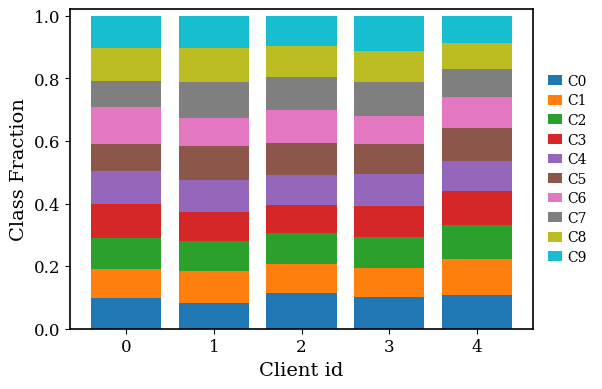

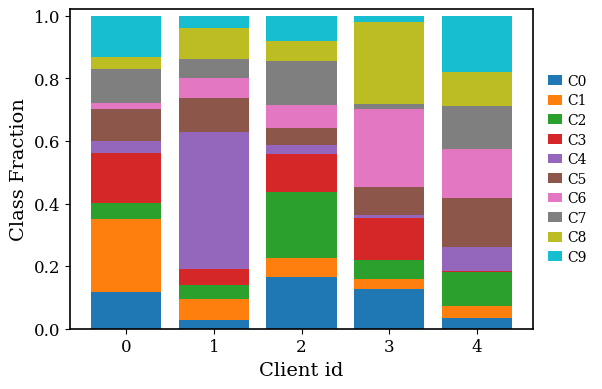

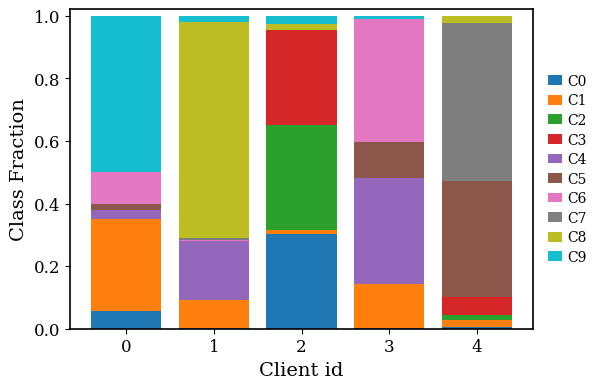

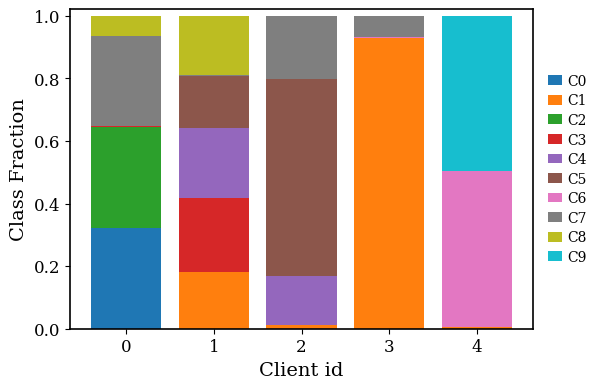

In [47]:
# cell 7 plot class mix for each alpha to show label skew

def plot_class_mix_grid(mix, alpha, save_dir=None):
    # mix is num_clients by num_classes counts
    fig, ax = plt.subplots(figsize=(7.5, 4))  # a bit wider to host the legend on the right

    totals = mix.sum(axis=1, keepdims=True).astype(float)
    frac   = mix / np.maximum(totals, 1.0)

    left = np.zeros(frac.shape[0])
    for c in range(frac.shape[1]):
        ax.bar(np.arange(frac.shape[0]), frac[:, c], bottom=left, width=0.8, label=f"C{c}")
        left += frac[:, c]

    ax.set_xlabel("Client id")
    ax.set_ylabel("Class Fraction")
    ax.set_xticks(np.arange(frac.shape[0]))
    ax.set_ylim(0.0, 1.02)

    # legend on the right next to the graph
    # smaller font and tighter spacing so it does not waste space
    ax.legend(
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        ncol=1,
        frameon=False,
        fontsize=10,
        handlelength=1.0,
        handletextpad=0.4,
        labelspacing=0.4,
        borderaxespad=0.0
    )

    # reserve right margin inside figure so the legend sits clean without cropping
    plt.tight_layout(rect=[0, 0, 0.82, 1])

    if SAVE_FIGS:
        plt.savefig(os.path.join(save_dir or FIG_DIR, f"class_mix_alpha_{alpha}.pdf"), bbox_inches="tight")
    plt.show()

for a in ALPHAS:
    plot_class_mix_grid(alpha_to_mix[a], a)


In [48]:
# cell 8 helper functions for model state and drift

def get_state_vector(model):
    # flatten all params into one vector on cpu
    with torch.no_grad():
        return torch.cat([p.detach().view(-1).cpu() for p in model.parameters()])

def load_state(model, state_dict):
    model.load_state_dict(state_dict, strict=True)

def average_states_weighted(state_dicts, weights):
    # weights sum to one
    out = {}
    keys = state_dicts[0].keys()
    for k in keys:
        acc = 0
        for sd, w in zip(state_dicts, weights):
            acc = acc + sd[k] * w
        out[k] = acc
    return out

@torch.no_grad()
def eval_model(model, loader, device=DEVICE):
    model.eval()
    correct = 0
    total = 0
    loss_sum = 0.0
    crit = nn.CrossEntropyLoss(reduction="sum")
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        logits = model(x)
        loss = crit(logits, y)
        loss_sum += loss.item()
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total   += y.size(0)
    return loss_sum / total, correct / total

def make_optimizer(model, lr=LR, momentum=MOMENTUM, wd=WEIGHT_DECAY):
    return torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=wd)


In [49]:
# cell 9 one client local train step

def client_train_one(model, loader, local_epochs=LOCAL_EPOCHS, device=DEVICE):
    model.train()
    opt = make_optimizer(model)
    crit = nn.CrossEntropyLoss()
    for _ in range(local_epochs):
        for x, y in loader:
            x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
            opt.zero_grad(set_to_none=True)
            logits = model(x)
            loss = crit(logits, y)
            loss.backward()
            opt.step()
    return model


In [50]:
# cell 10 fedavg main loop for one alpha

def run_fedavg(alpha, init_state_dict, rounds=ROUNDS, verbose=True):
    loaders, sizes = alpha_to_splits[alpha]
    total_size = float(sum(sizes))
    weights = [s / total_size for s in sizes]

    # make fresh global model and load same init for fairness
    global_model = SmallCNN().to(DEVICE)
    load_state(global_model, copy.deepcopy(init_state_dict))

    # history
    test_acc_hist = []
    test_loss_hist = []
    drift_hist     = []
    per_round_time = []

    for t in range(rounds):
        round_start = time.time()
        # capture global vector before local work for drift calc
        g_vec = get_state_vector(global_model)

        client_states = []
        client_drift_vals = []

        # broadcast and local train for all clients
        for i, loader in enumerate(loaders):
            local_model = SmallCNN().to(DEVICE)
            load_state(local_model, copy.deepcopy(global_model.state_dict()))
            # train local
            client_train_one(local_model, loader)
            # collect state
            client_states.append(copy.deepcopy(local_model.state_dict()))
            # drift is norm of theta_i minus theta_g before round
            diff = get_state_vector(local_model) - g_vec
            client_drift_vals.append(torch.norm(diff, p=2).item())

        # aggregate on server with size weights
        new_global = average_states_weighted(client_states, weights)
        load_state(global_model, new_global)

        # eval on test
        tloss, tacc = eval_model(global_model, test_loader)
        test_loss_hist.append(tloss)
        test_acc_hist.append(tacc)

        # store mean drift for this round
        drift_hist.append(float(np.mean(client_drift_vals)))
        per_round_time.append(time.time() - round_start)

        if verbose:
            print(f"alpha {alpha} round {t+1}/{rounds} acc {tacc:.4f} drift {drift_hist[-1]:.2f} time {human_time(per_round_time[-1])}")

    result = {
        "alpha": alpha,
        "test_acc": np.array(test_acc_hist),
        "test_loss": np.array(test_loss_hist),
        "drift": np.array(drift_hist),
        "round_time": np.array(per_round_time),
        "final_acc": float(test_acc_hist[-1]),
        "avg_drift": float(np.mean(drift_hist)),
        "sizes": sizes
    }
    return result, global_model


In [51]:
# cell 11 run experiments for all alphas

# fix a single init so all runs start from same weights
init_state = SmallCNN().state_dict()

alpha_results = {}
alpha_final_models = {}

start = time.time()
for a in ALPHAS:
    res, model = run_fedavg(a, init_state_dict=init_state, rounds=ROUNDS, verbose=True)
    alpha_results[a] = res
    alpha_final_models[a] = model
print("all runs done in", human_time(time.time() - start))


alpha 100.0 round 1/20 acc 0.4316 drift 6.62 time 1m 51s
alpha 100.0 round 2/20 acc 0.6285 drift 5.81 time 1m 51s
alpha 100.0 round 3/20 acc 0.6808 drift 4.96 time 1m 50s
alpha 100.0 round 4/20 acc 0.7092 drift 4.58 time 1m 49s
alpha 100.0 round 5/20 acc 0.7282 drift 4.41 time 1m 49s
alpha 100.0 round 6/20 acc 0.7396 drift 4.38 time 1m 49s
alpha 100.0 round 7/20 acc 0.7457 drift 4.37 time 1m 49s
alpha 100.0 round 8/20 acc 0.7554 drift 4.39 time 1m 48s
alpha 100.0 round 9/20 acc 0.7590 drift 4.43 time 1m 48s
alpha 100.0 round 10/20 acc 0.7719 drift 4.45 time 1m 48s
alpha 100.0 round 11/20 acc 0.7754 drift 4.49 time 1m 49s
alpha 100.0 round 12/20 acc 0.7767 drift 4.51 time 1m 48s
alpha 100.0 round 13/20 acc 0.7864 drift 4.51 time 1m 49s
alpha 100.0 round 14/20 acc 0.7886 drift 4.54 time 1m 49s
alpha 100.0 round 15/20 acc 0.7919 drift 4.58 time 1m 48s
alpha 100.0 round 16/20 acc 0.7863 drift 4.63 time 1m 48s
alpha 100.0 round 17/20 acc 0.7971 drift 4.64 time 1m 47s
alpha 100.0 round 18/20

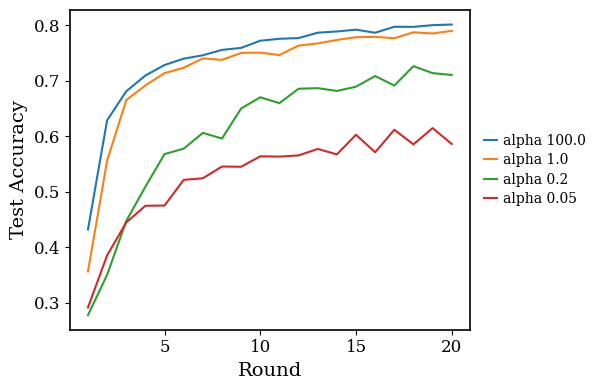

In [62]:
# cell 12 plot accuracy vs rounds for each alpha

fig, ax = plt.subplots(figsize=(7.5, 4))
for a in ALPHAS:
    acc = alpha_results[a]["test_acc"]
    ax.plot(np.arange(1, len(acc)+1), acc, label=f"alpha {a}")

ax.set_xlabel("Round")
ax.set_ylabel("Test Accuracy")

ax.legend(
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    ncol=1,
    frameon=False,
    fontsize=10,
    handlelength=1.0,
    handletextpad=0.4,
    labelspacing=0.4,
    borderaxespad=0.0
)
plt.tight_layout(rect=[0, 0, 0.82, 1])

if SAVE_FIGS:
    plt.savefig(os.path.join(FIG_DIR, "acc_vs_rounds_task3.pdf"), bbox_inches="tight")
plt.show()


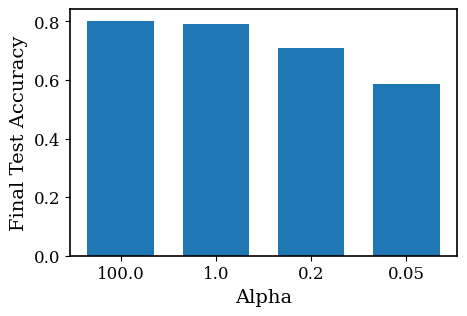

In [63]:
# cell 12a final test accuracy bar per alpha

fig, ax = plt.subplots(figsize=(5,3.2))
final_vals = [alpha_results[a]["final_acc"] for a in ALPHAS]
ax.bar([str(a) for a in ALPHAS], final_vals, width=0.7)
ax.set_xlabel("Alpha")
ax.set_ylabel("Final Test Accuracy")
if SAVE_FIGS:
    plt.savefig(os.path.join(FIG_DIR, "final_acc_bar_task3.pdf"), bbox_inches="tight")
plt.show()


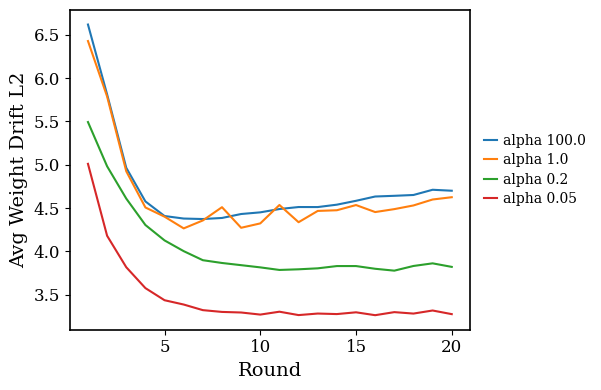

In [64]:
# cell 13 plot drift vs rounds for each alpha

fig, ax = plt.subplots(figsize=(7.5, 4))
for a in ALPHAS:
    drift = alpha_results[a]["drift"]
    ax.plot(np.arange(1, len(drift)+1), drift, label=f"alpha {a}")

ax.set_xlabel("Round")
ax.set_ylabel("Avg Weight Drift L2")

ax.legend(
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    ncol=1,
    frameon=False,
    fontsize=10,
    handlelength=1.0,
    handletextpad=0.4,
    labelspacing=0.4,
    borderaxespad=0.0
)
plt.tight_layout(rect=[0, 0, 0.82, 1])

if SAVE_FIGS:
    plt.savefig(os.path.join(FIG_DIR, "drift_vs_rounds_task3.pdf"), bbox_inches="tight")
plt.show()


In [65]:
# cell 14 summary table of final numbers as the task asks

rows = []
for a in ALPHAS:
    res = alpha_results[a]
    rows.append({
        "alpha": a,
        "final_test_acc": res["final_acc"],
        "mean_drift": res["avg_drift"],
        "total_train_points": int(sum(res["sizes"])),
        "rounds": ROUNDS,
        "local_epochs": LOCAL_EPOCHS
    })
summary_df = pd.DataFrame(rows).sort_values("alpha", ascending=False).reset_index(drop=True)
print(summary_df.to_string(index=False))


 alpha  final_test_acc  mean_drift  total_train_points  rounds  local_epochs
100.00          0.8011    4.718125               50000      20             5
  1.00          0.7897    4.640459               50000      20             5
  0.20          0.7102    4.052779               50000      20             5
  0.05          0.5858    3.471473               50000      20             5


In [66]:
# cell 14a latex table string for icml paper paste

latex_tbl = summary_df.to_latex(index=False, float_format=lambda x: f"{x:.4f}")
print(latex_tbl)


\begin{tabular}{rrrrrr}
\toprule
alpha & final_test_acc & mean_drift & total_train_points & rounds & local_epochs \\
\midrule
100.0000 & 0.8011 & 4.7181 & 50000 & 20 & 5 \\
1.0000 & 0.7897 & 4.6405 & 50000 & 20 & 5 \\
0.2000 & 0.7102 & 4.0528 & 50000 & 20 & 5 \\
0.0500 & 0.5858 & 3.4715 & 50000 & 20 & 5 \\
\bottomrule
\end{tabular}



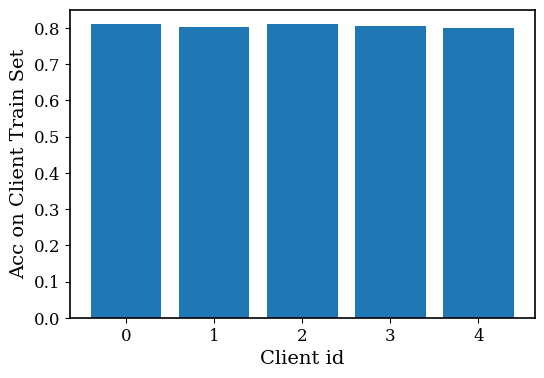

alpha 100.0 per client train acc: [0.81   0.804  0.8099 0.8055 0.8002]


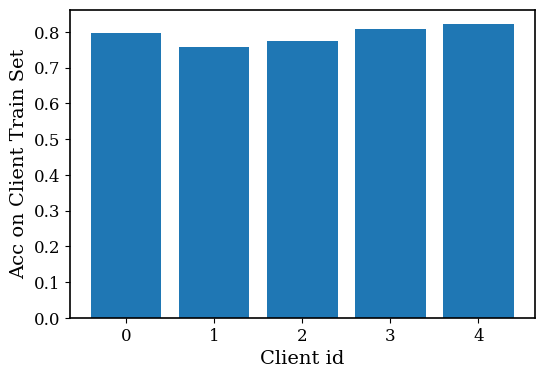

alpha 1.0 per client train acc: [0.7983 0.7568 0.7736 0.808  0.8212]


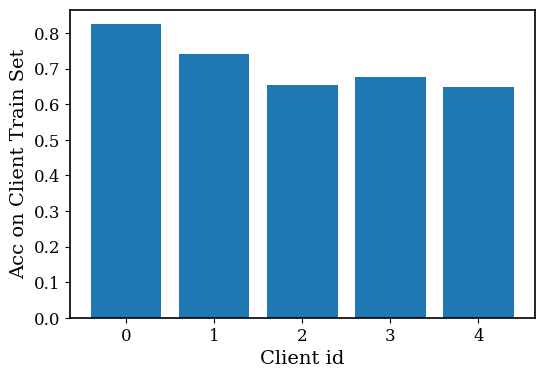

alpha 0.2 per client train acc: [0.8244 0.7399 0.654  0.6774 0.6489]


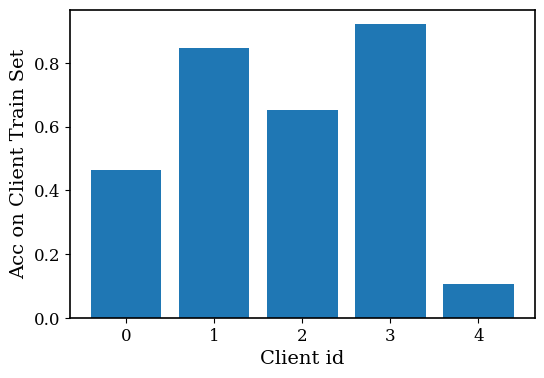

alpha 0.05 per client train acc: [0.4625 0.8464 0.6529 0.9206 0.1069]


In [67]:
# cell 15 per client accuracy snapshot for last global model for each alpha

def eval_on_client_sets(model, splits, batch_size=BATCH_SIZE):
    accs = []
    for idxs in splits:
        loader = DataLoader(
                Subset(train_set, idxs),
                batch_size=256,
                shuffle=False,
                num_workers=NUM_WORKERS,          # this is 0 now
                pin_memory=(DEVICE.type == "cuda")
            )

        _, acc = eval_model(model, loader)
        accs.append(acc)
    return np.array(accs)

for a in ALPHAS:
    model = alpha_final_models[a]
    splits = alpha_to_splits[a][0]  # loaders not needed
    # rebuild indices list from stored splits to compute client acc on their local train sets
    idxs_list = dirichlet_partition(y_all, NUM_CLIENTS, a, min_size=1)  # placeholder not used
    # better extract from saved indices to be faithful
    # we can reconstruct from the subset objects inside each loader
    real_indices = []
    for ld in alpha_to_splits[a][0]:
        # Subset in DataLoader can be accessed via dataset.indices inside the Subset object
        real_indices.append(ld.dataset.indices)
    client_accs = eval_on_client_sets(model, real_indices)

    fig, ax = plt.subplots(figsize=(6,4))
    ax.bar(np.arange(NUM_CLIENTS), client_accs, width=0.8)
    ax.set_xlabel("Client id")
    ax.set_ylabel("Acc on Client Train Set")
    ax.set_xticks(np.arange(NUM_CLIENTS))
    if SAVE_FIGS:
        plt.savefig(os.path.join(FIG_DIR, f"client_train_acc_alpha_{a}.pdf"), bbox_inches="tight")
    plt.show()

    print(f"alpha {a} per client train acc:", np.round(client_accs, 4))


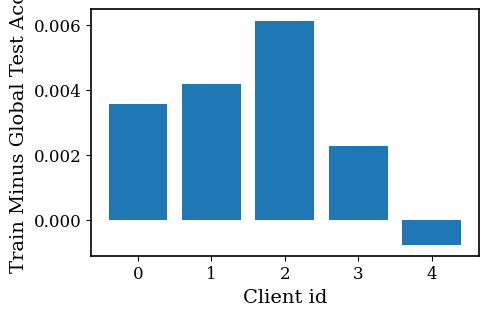

alpha 100.0 mean client train acc 0.8042 global test acc 0.8011 mean gap 0.0031


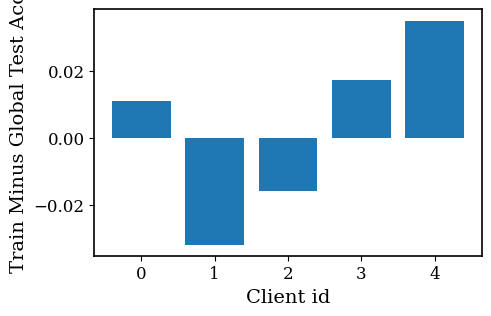

alpha 1.0 mean client train acc 0.7929 global test acc 0.7897 mean gap 0.0032


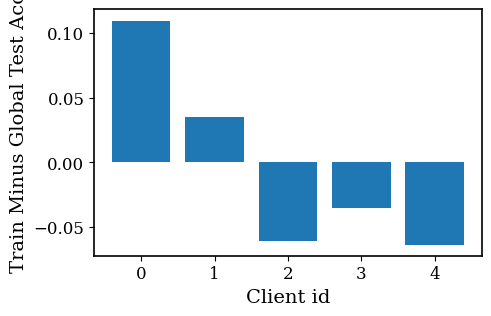

alpha 0.2 mean client train acc 0.7074 global test acc 0.7102 mean gap -0.0028


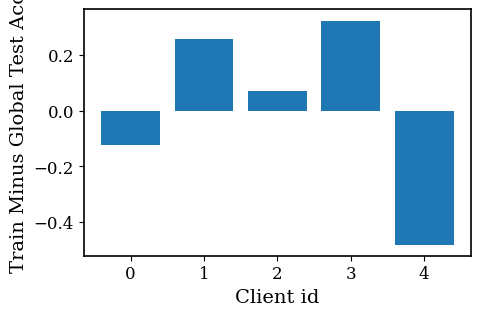

alpha 0.05 mean client train acc 0.5960 global test acc 0.5858 mean gap 0.0102


In [68]:
# cell 15a visualize the gap between client train acc and global test acc

def get_indices_from_loaders(loaders):
    # loaders were made from Subset so we can access .indices
    idxs = []
    for ld in loaders:
        idxs.append(ld.dataset.indices)
    return idxs

for a in ALPHAS:
    model = alpha_final_models[a]
    loaders, _ = alpha_to_splits[a]
    idxs_list = get_indices_from_loaders(loaders)

    # client train accs
    client_accs = []
    for idxs in idxs_list:
        loader = DataLoader(
              Subset(train_set, idxs),
              batch_size=256,
              shuffle=False,
              num_workers=NUM_WORKERS,          # this is 0 now
              pin_memory=(DEVICE.type == "cuda")
          )

        _, acc = eval_model(model, loader)
        client_accs.append(acc)
    client_accs = np.array(client_accs)

    # global test acc
    _, gtest = eval_model(model, test_loader)

    # plot train minus test gap per client
    fig, ax = plt.subplots(figsize=(5,3.2))
    ax.bar(np.arange(NUM_CLIENTS), client_accs - gtest, width=0.8)
    ax.set_xlabel("Client id")
    ax.set_ylabel("Train Minus Global Test Acc")
    ax.set_xticks(np.arange(NUM_CLIENTS))
    if SAVE_FIGS:
        plt.savefig(os.path.join(FIG_DIR, f"gap_train_vs_test_alpha_{a}.pdf"), bbox_inches="tight")
    plt.show()

    print(f"alpha {a} mean client train acc {client_accs.mean():.4f} global test acc {gtest:.4f} mean gap {float(client_accs.mean() - gtest):.4f}")


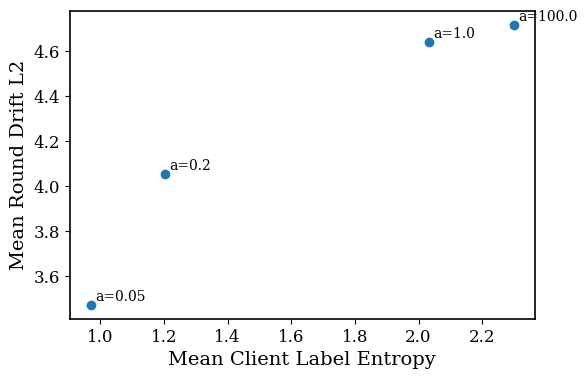

In [69]:
# cell 16 extra figure link between label skew and drift

# we measure entropy of label mix per client then average across clients
def mean_entropy_of_mix(mix):
    eps = 1e-12
    mix = mix.astype(np.float64)
    mix = mix / mix.sum(axis=1, keepdims=True)
    mix = np.clip(mix, eps, 1.0)
    ent = -np.sum(mix * np.log(mix), axis=1)
    return float(np.mean(ent))

alpha_mean_entropy = []
alpha_mean_drift   = []
for a in ALPHAS:
    alpha_mean_entropy.append(mean_entropy_of_mix(alpha_to_mix[a]))
    alpha_mean_drift.append(alpha_results[a]["avg_drift"])

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(alpha_mean_entropy, alpha_mean_drift)
for i, a in enumerate(ALPHAS):
    ax.annotate(f"a={a}", (alpha_mean_entropy[i], alpha_mean_drift[i]), xytext=(3,3), textcoords="offset points")
ax.set_xlabel("Mean Client Label Entropy")
ax.set_ylabel("Mean Round Drift L2")
if SAVE_FIGS:
    plt.savefig(os.path.join(FIG_DIR, "entropy_vs_drift_task3.pdf"), bbox_inches="tight")
plt.show()


In [70]:
# cell 17 print quick notes that help report writing

for a in ALPHAS:
    res = alpha_results[a]
    acc_curve = res["test_acc"]
    best_acc  = float(np.max(acc_curve))
    print(f"alpha {a} final acc {res['final_acc']:.4f} best acc {best_acc:.4f} mean drift {res['avg_drift']:.2f}")


alpha 100.0 final acc 0.8011 best acc 0.8011 mean drift 4.72
alpha 1.0 final acc 0.7897 best acc 0.7897 mean drift 4.64
alpha 0.2 final acc 0.7102 best acc 0.7261 mean drift 4.05
alpha 0.05 final acc 0.5858 best acc 0.6145 mean drift 3.47


central round 1 acc 0.686
central round 2 acc 0.7262
central round 3 acc 0.7441
central round 4 acc 0.7657
central round 5 acc 0.7736
central round 6 acc 0.7863
central round 7 acc 0.7789
central round 8 acc 0.7768
central round 9 acc 0.7931
central round 10 acc 0.7936
central round 11 acc 0.7961
central round 12 acc 0.7933
central round 13 acc 0.7992
central round 14 acc 0.811
central round 15 acc 0.8153
central round 16 acc 0.792
central round 17 acc 0.8094
central round 18 acc 0.8168
central round 19 acc 0.814
central round 20 acc 0.8135


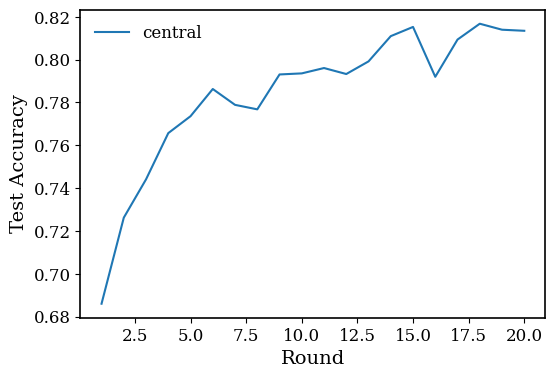

In [73]:
# cell 18 sanity check central run optional dont run if time is tight

# this is optional quick central baseline to anchor the iid case without full task one
RUN_CENTRAL = True
if RUN_CENTRAL:
    central = SmallCNN().to(DEVICE)
    load_state(central, copy.deepcopy(init_state))
    opt = make_optimizer(central)
    crit = nn.CrossEntropyLoss()

    central_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
    acc_hist = []
    for r in range(ROUNDS):
        central.train()
        for _ in range(LOCAL_EPOCHS):
            for x, y in central_loader:
                x, y = x.to(DEVICE), y.to(DEVICE)
                opt.zero_grad(set_to_none=True)
                out = central(x)
                loss = crit(out, y)
                loss.backward()
                opt.step()
        _, tacc = eval_model(central, test_loader)
        acc_hist.append(tacc)
        print("central round", r+1, "acc", tacc)

    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(np.arange(1, len(acc_hist)+1), acc_hist, label="central")
    ax.set_xlabel("Round")
    ax.set_ylabel("Test Accuracy")
    ax.legend(frameon=False)
    if SAVE_FIGS:
        plt.savefig(os.path.join(FIG_DIR, "central_acc_vs_rounds_task3.pdf"), bbox_inches="tight")
    plt.show()
